# Part 2: Search Optimization with Average Vector + Rescoring

This notebook demonstrates the **Average Vector and Rescoring** techniques from Elastic's Search Labs blog post, '[Scaling late interaction models in Elasticsearch](https://www.elastic.co/search-labs/blog/scale-late-interaction-model-colpali)'.

**Demo Scenario:**

1.  **Problem Definition**: For large-scale search, we create a single average vector per document to leverage Elasticsearch's fast `knn` search.
2.  **Identifying the Trade-off**: We observe a drop in search quality (ranking degradation) when using `knn` search alone, compared to the high-quality results from Part 1.
3.  **Presenting the Solution**: We use Elasticsearch's `rescore` API to perform a precise, secondary scoring calculation on the initial `knn` results using `rank_vectors`.
4.  **Verifying the Result**: We show that rescoring successfully restores the top-quality document to the #1 rank, proving the effectiveness of this two-stage architecture.

### Step 0: Environment Setup and Library Installation

**[EN]** Install the necessary libraries, same as in Part 1.<br>
**[KR]** Part 1과 동일하게 필요한 라이브러리를 설치합니다.

In [1]:
!pip install -q "git+https://github.com/illuin-tech/colpali.git"
!pip install -q "transformers>=4.41.0" accelerate Pillow elasticsearch python-dotenv tqdm numpy


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


### Step 1: Import Libraries and Set Environment Variables

**[EN]** Use the same environment setup as in Part 1. Define a new index name and field names for this optimization demo.<br>
**[KR]** Part 1과 동일한 환경 설정을 사용합니다. 이번 최적화 데모를 위해 새로운 인덱스 이름과 필드 이름을 정의합니다.

In [2]:
import torch
import os
import glob
import base64
import numpy as np
from io import BytesIO
from tqdm.notebook import tqdm
from PIL import Image
from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from IPython.display import display, HTML

dotenv_path = 'elastic.env'
load_dotenv(dotenv_path=dotenv_path)

ES_URL = os.getenv("ES_URL")
ES_API_KEY = os.getenv("ES_API_KEY")

if not ES_URL or not ES_API_KEY:
    raise ValueError(f"Please create an '{dotenv_path}' file and set ES_URL and ES_API_KEY variables.")

INDEX_NAME = "colqwen-rvlcdip-demo-part2"
VECTOR_FIELD_NAME = "colqwen_vectors"
AVG_VECTOR_FIELD_NAME = "colqwen_avg_vector"
SAMPLED_DATA_DIR = "samples/"

### Step 2: Load ColQwen Model and Verify Data Path

**[EN]** Load the same model as in Part 1 and verify the path to the RVL-CDIP dataset.<br>
**[KR]** Part 1과 동일한 모델을 로드하고, RVL-CDIP 데이터셋 경로를 확인합니다.

In [3]:
from colpali_engine.models import ColQwen2_5, ColQwen2_5_Processor

device_map = "cpu"
if torch.backends.mps.is_available():
    device_map = "mps"
elif torch.cuda.is_available():
    device_map = "cuda:0"
print(f"Using device: {device_map}")

MODEL_NAME = "tsystems/colqwen2.5-3b-multilingual-v1.0"
model = ColQwen2_5.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device_map != "cpu" else torch.float32,
    device_map=device_map
).eval()

processor = ColQwen2_5_Processor.from_pretrained(MODEL_NAME)
print(f"Model '{MODEL_NAME}' loaded successfully.")

image_paths = []
if os.path.exists(SAMPLED_DATA_DIR):
    for category_dir in os.listdir(SAMPLED_DATA_DIR):
        full_category_path = os.path.join(SAMPLED_DATA_DIR, category_dir)
        if os.path.isdir(full_category_path):
            image_paths.extend(glob.glob(os.path.join(full_category_path, '*.*')))
print(f"Found {len(image_paths)} sample images.")

Using device: cuda:0


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Model 'tsystems/colqwen2.5-3b-multilingual-v1.0' loaded successfully.
Found 1600 sample images.


### Step 3: Define Helper Functions for Embeddings

**[EN]** In addition to the existing embedding functions, define a new function to calculate a single, normalized average vector from a set of multi-vectors.<br>
**[KR]** 기존 임베딩 생성 함수와 더불어, 다중 벡터를 입력받아 정규화된 단일 평균 벡터를 계산하는 함수를 추가로 정의합니다.

In [4]:
def create_colqwen_document_vectors(image_path):
    """Generates multi-vector embeddings for a document image."""
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor.process_images([image]).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.cpu().to(torch.float32).numpy().tolist()[0]
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def create_colqwen_query_vectors(query_text):
    """Generates multi-vector embeddings for a text query."""
    inputs = processor.process_queries([query_text]).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.cpu().to(torch.float32).numpy().tolist()[0]

def calculate_average_vector(vectors):
    """Calculates a single, normalized average vector from multi-vectors."""
    if not vectors or len(vectors) == 0:
        return None
    avg_vec = np.array(vectors).mean(axis=0)
    norm = np.linalg.norm(avg_vec)
    if norm == 0:
        return avg_vec.tolist()
    return (avg_vec / norm).tolist()

def to_bit_vectors(embeddings: list) -> list:
    """
    Converts a list of float vectors into a list of hex-encoded bit vectors
    for use with rank_vectors fields where element_type is 'bit'.
    """
    return [
        np.packbits(np.where(np.array(embedding) > 0, 1, 0))
        .astype(np.int8)
        .tobytes()
        .hex()
        for embedding in embeddings
    ]

### Step 4: Create Elasticsearch Index with Two Vector Fields

**[EN]** This is the core of the demo. We create an index with both a `dense_vector` field for the average vector (for `knn` search) and a `rank_vectors` field for the original multi-vectors (for `rescoring`).<br>
**[KR]** 이 데모의 핵심입니다. 하나의 인덱스에 `knn` 검색을 위한 `dense_vector` 타입의 평균 벡터 필드와 `rescoring`을 위한 `rank_vectors` 타입의 원본 다중 벡터 필드를 모두 생성합니다.

In [5]:
# Automatically detect if ES_URL is a Cloud ID or a Host URL.
if ':' in ES_URL and not ES_URL.startswith('http'):
    # Connect using Cloud ID
    print("Connecting using Cloud ID...")
    es = Elasticsearch(
        cloud_id=ES_URL,
        api_key=ES_API_KEY,
        request_timeout=10
    )
else:
    # Connect using Host URL
    print("Connecting using Host URL...")
    es = Elasticsearch(
        hosts=[ES_URL],
        api_key=ES_API_KEY,
        request_timeout=10
    )

print(f"Connected to Elasticsearch version: {es.info()['version']['number']}")

# Define the index mapping with all optimizations.
# 1. dense_vector uses automatic BBQ via index_options.
# 2. rank_vectors uses manual binary quantization via element_type: 'bit'.
mapping = {
    "properties": {
        AVG_VECTOR_FIELD_NAME: {
            "type": "dense_vector",
            "dims": 128,
            "index": True,
            "similarity": "dot_product",
            "index_options": {
                "type": "bbq_hnsw"
            }
        },
        VECTOR_FIELD_NAME: {
            "type": "rank_vectors",
            "dims": 128,
            "element_type": "bit"
        },
        "image_path": {"type": "keyword"},
        "category": {"type": "keyword"}
    }
}

# Check if the index already exists and is valid (has 1600 documents).
# If not, recreate it to ensure data integrity.
if es.indices.exists(index=INDEX_NAME):
    try:
        doc_count = es.count(index=INDEX_NAME)['count']
        print(f"Index '{INDEX_NAME}' already exists with {doc_count} documents.")
        if doc_count != 1600:
            print("Document count is incorrect. Re-indexing...")
            es.indices.delete(index=INDEX_NAME)
            es.indices.create(index=INDEX_NAME, mappings=mapping)
        else:
            print("Index is valid.")
    except Exception as e:
        print(f"Error checking index: {e}. Recreating index.")
        es.indices.delete(index=INDEX_NAME)
        es.indices.create(index=INDEX_NAME, mappings=mapping)
else:
    print(f"Index '{INDEX_NAME}' not found. Creating new index.")
    es.indices.create(index=INDEX_NAME, mappings=mapping)

Connecting using Host URL...
Connected to Elasticsearch version: 8.11.0
Index 'colqwen-rvlcdip-demo-part2' already exists with 1600 documents.
Index is valid.


### Step 5: Index the Data (If Necessary)

**[EN]** If the index was newly created or invalid, index all 1600 documents. This time, we generate and store both the average vector and the original multi-vectors for each document.<br>
**[KR]** 인덱스가 새로 생성되었거나 유효하지 않은 경우, 1600개의 문서를 모두 인덱싱합니다. 이번에는 각 문서에 대해 평균 벡터와 원본 다중 벡터를 모두 생성하여 저장합니다.

In [6]:
doc_count = es.count(index=INDEX_NAME)['count']
if doc_count < 1600:
    MAX_DOCS_TO_INDEX = 1600
    docs_to_index = image_paths[:min(len(image_paths), MAX_DOCS_TO_INDEX)]
    print(f"Indexing {len(docs_to_index)} documents...")

    for path in tqdm(docs_to_index, desc="Indexing Documents"):
        doc_id = os.path.splitext(os.path.basename(path))[0]
        category = os.path.basename(os.path.dirname(path))
        
        # Generate both multi-vectors and the average vector
        multi_vectors = create_colqwen_document_vectors(path)
        if multi_vectors:
            avg_vector = calculate_average_vector(multi_vectors)
            bit_vectors = to_bit_vectors(multi_vectors)
            
            es_doc = {
                VECTOR_FIELD_NAME: bit_vectors,
                AVG_VECTOR_FIELD_NAME: avg_vector,
                "image_path": path,
                "category": category
            }
            es.index(index=INDEX_NAME, id=doc_id, document=es_doc)

    es.indices.refresh(index=INDEX_NAME)
    print("\nIndexing complete.")
else:
    print("All documents are already indexed.")

All documents are already indexed.


### Step 6: Demonstrate the Problem: KNN Search Only

**[EN]** First, let's perform a search using only the fast `knn` query. Pay attention to how the rank of the document that was #1 in Part 1 changes. This demonstrates the trade-off: we gain speed but lose some precision.<br>
**[KR]** 먼저 빠른 `knn` 검색만 사용하여 결과를 확인합니다. Part 1에서 1위를 차지했던 문서의 순위가 어떻게 변하는지 주목합니다. 이는 속도를 얻는 대신 정밀도를 일부 잃는 트레이드오프를 보여줍니다.


--- Scenario: B. KNN Search Only ---
Searching for: 'Please find the order form I received by fax in July.'
🚀 Search Latency: 79.58 ms



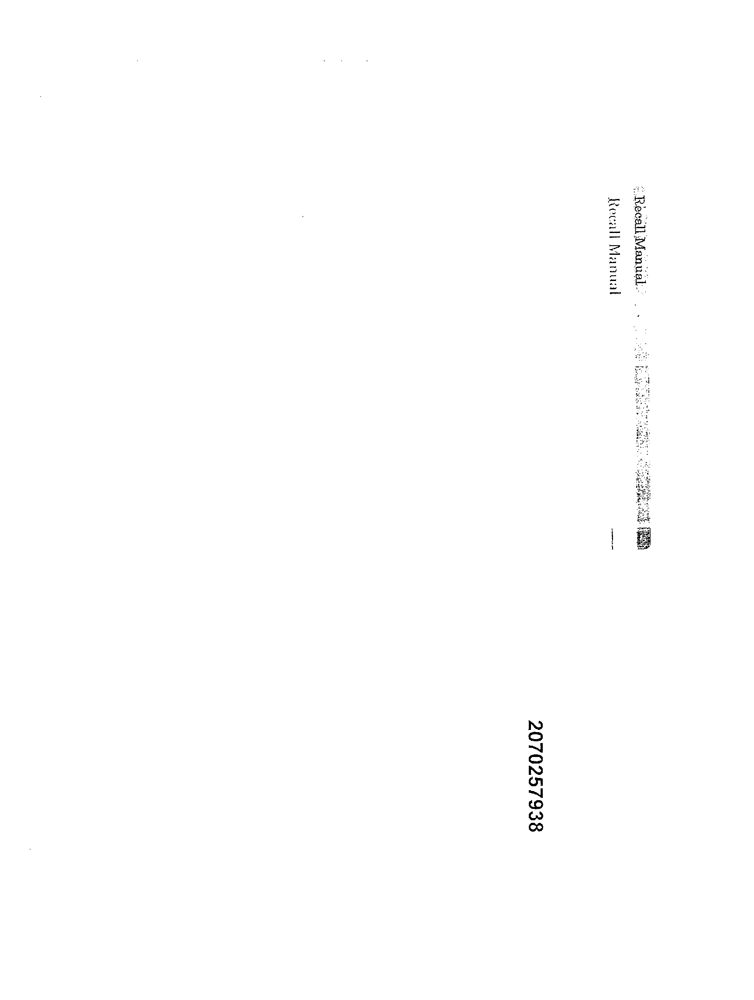
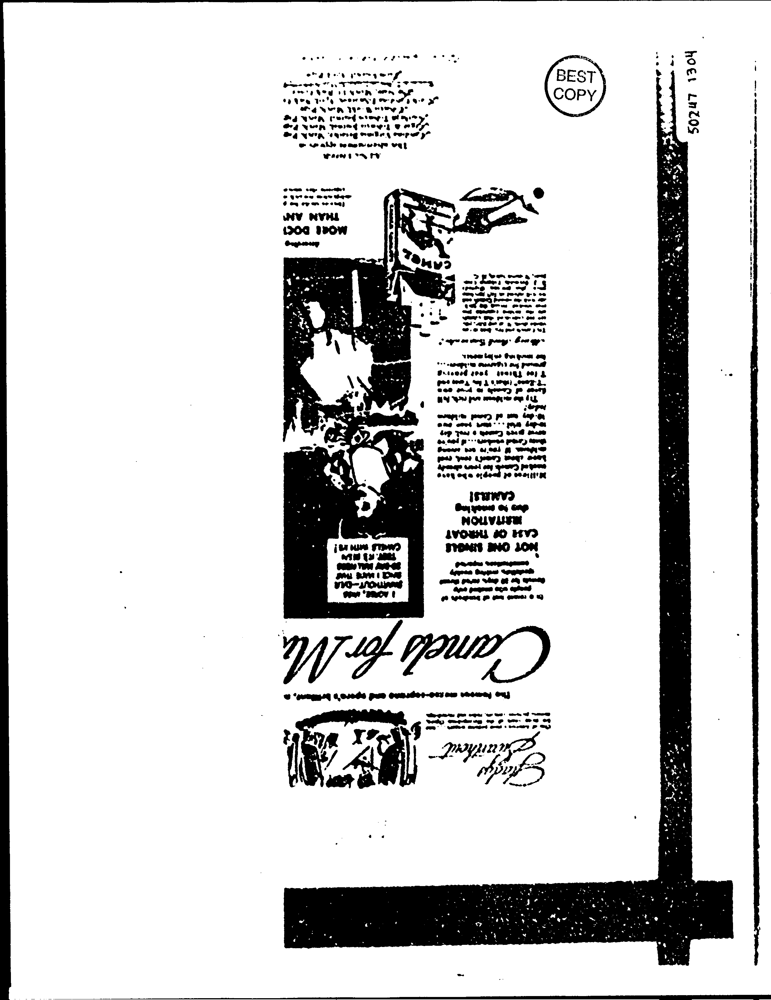
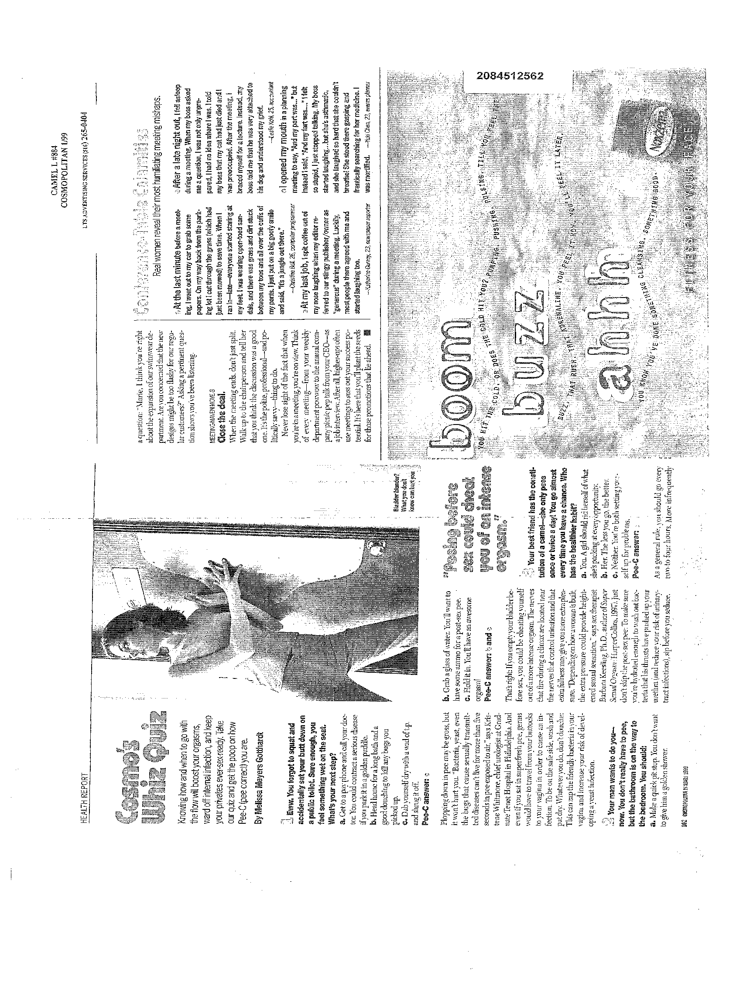
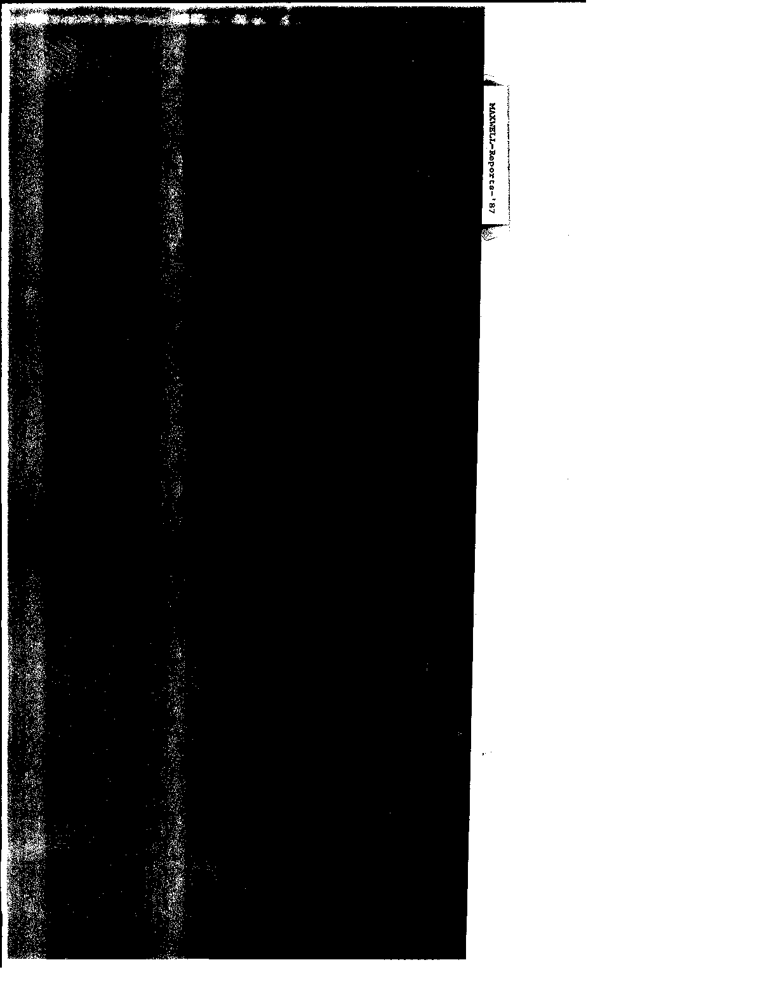
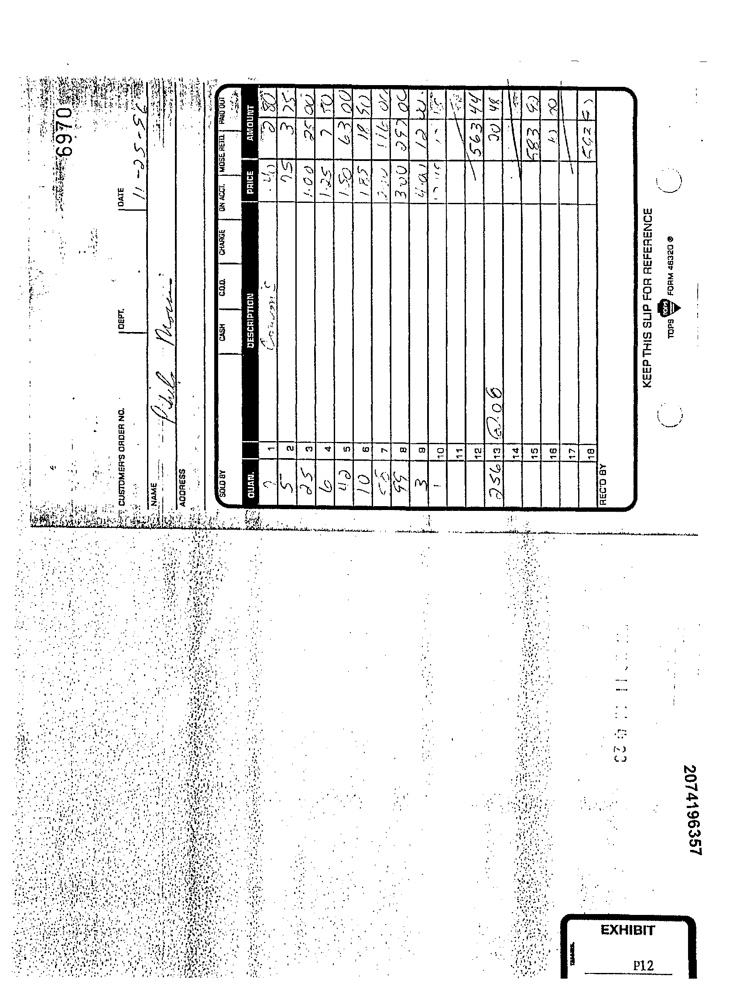


--- Explanation for Top Result (Rank #1) ---
{
  "value": 0.64337707,
  "description": "within top k documents",
  "details": []
}

--- Scenario: B. KNN Search Only ---
Searching for: '지난 7월에 fax 로 받은 발주서 찾아줘'
🚀 Search Latency: 79.32 ms



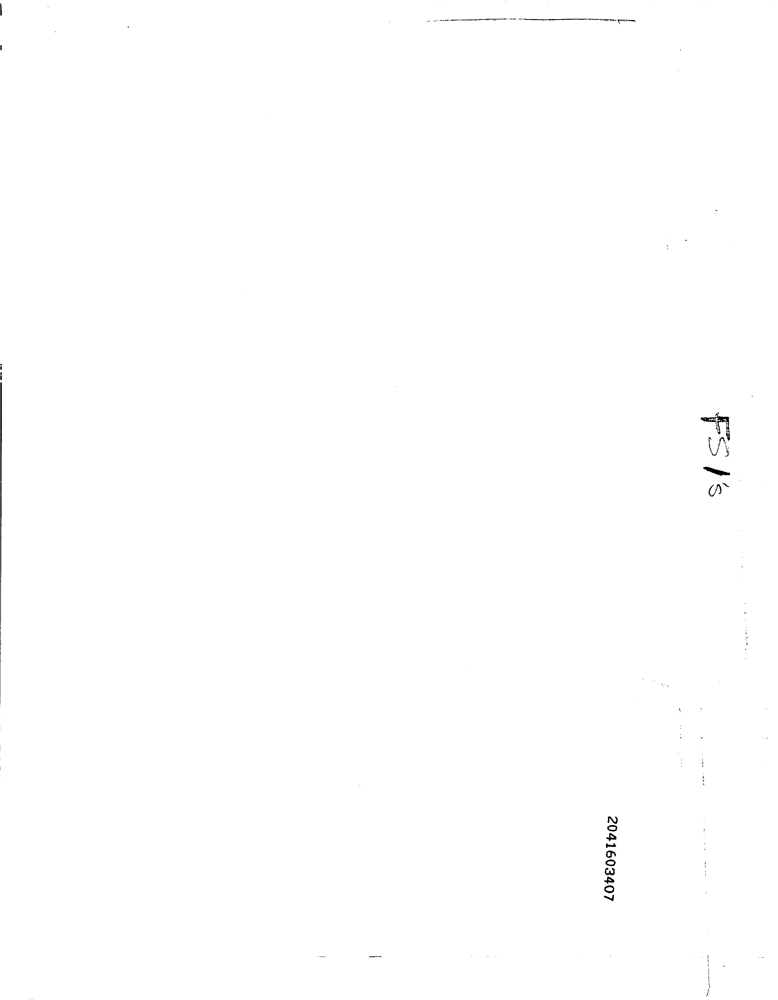
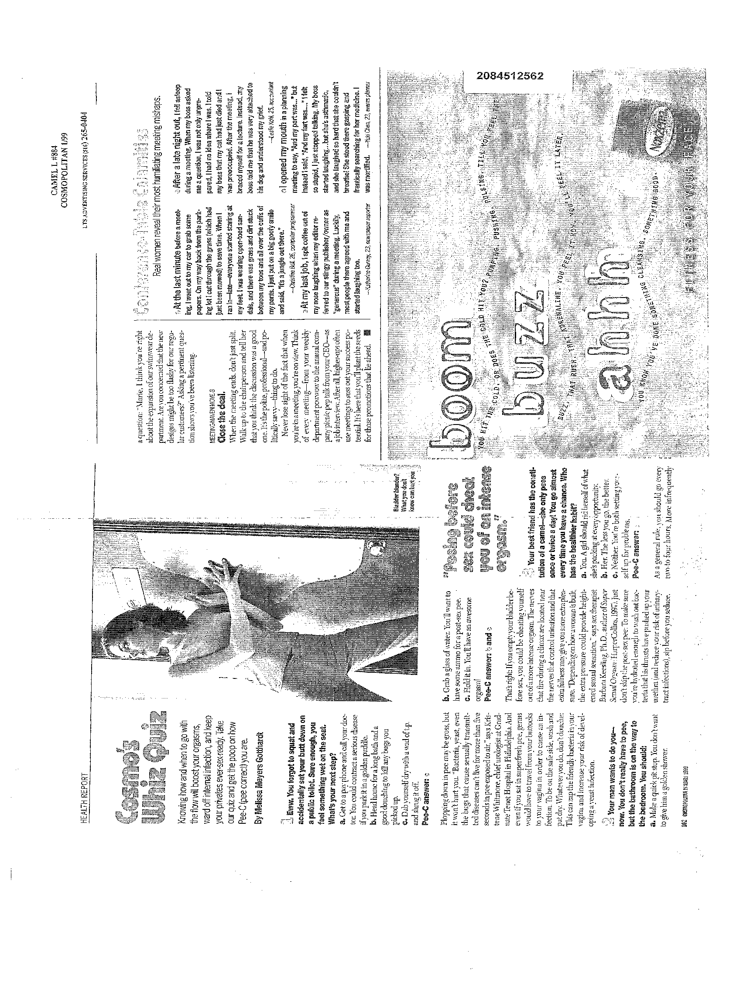
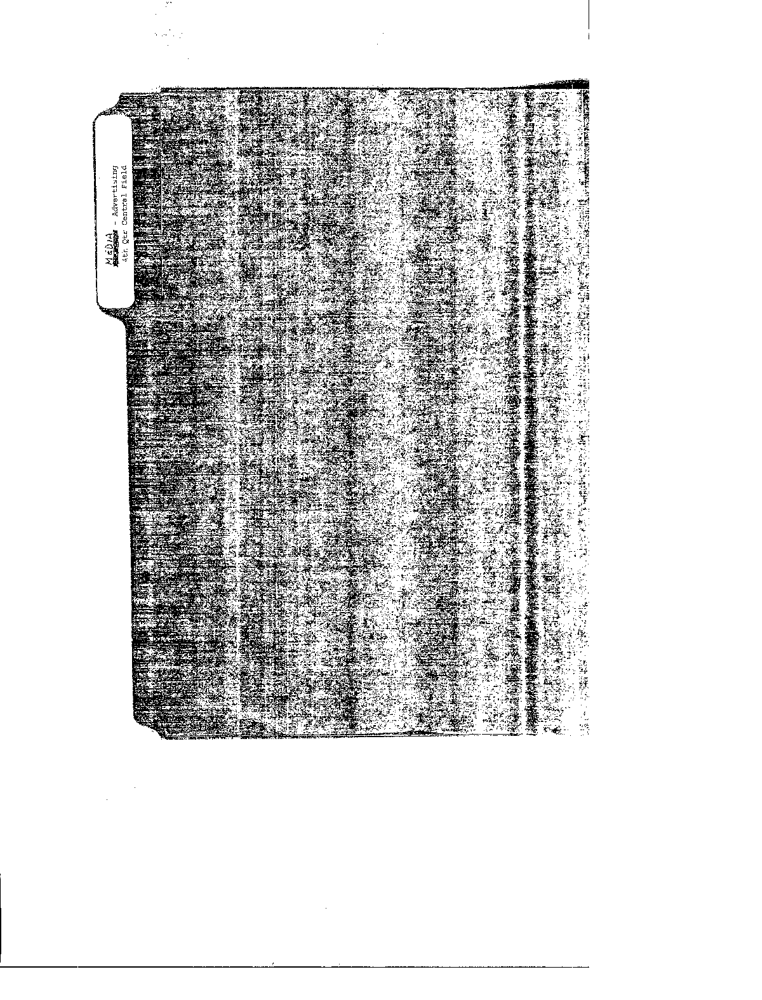
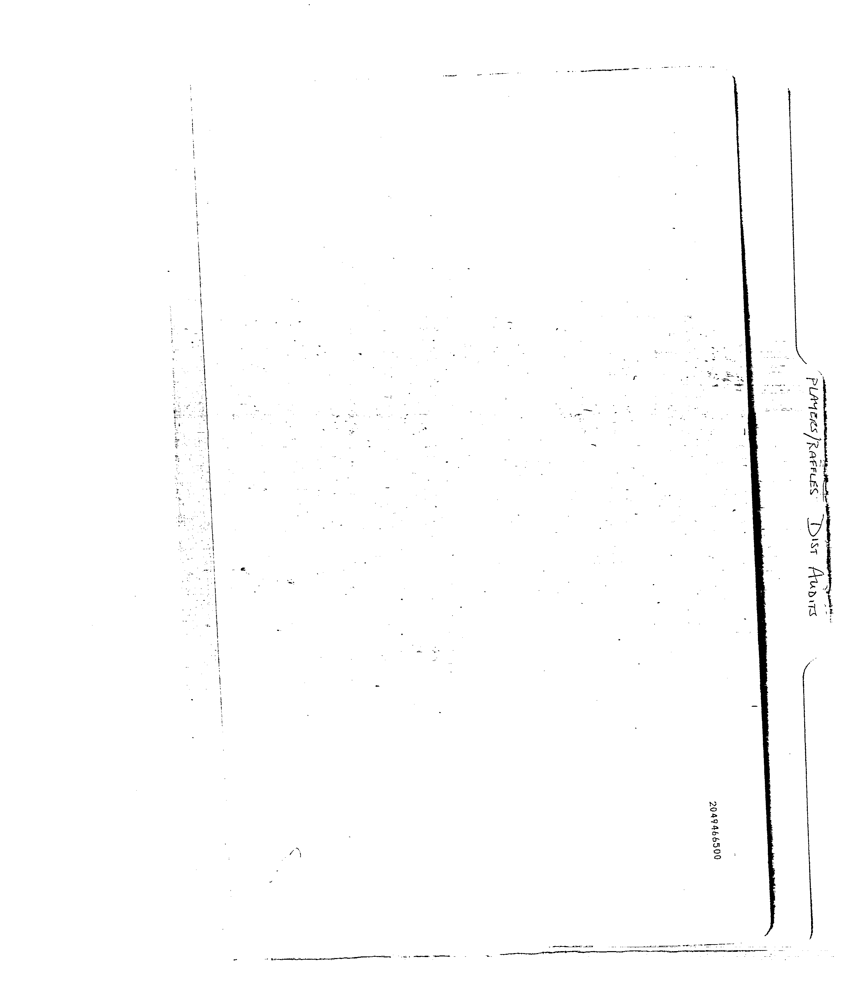
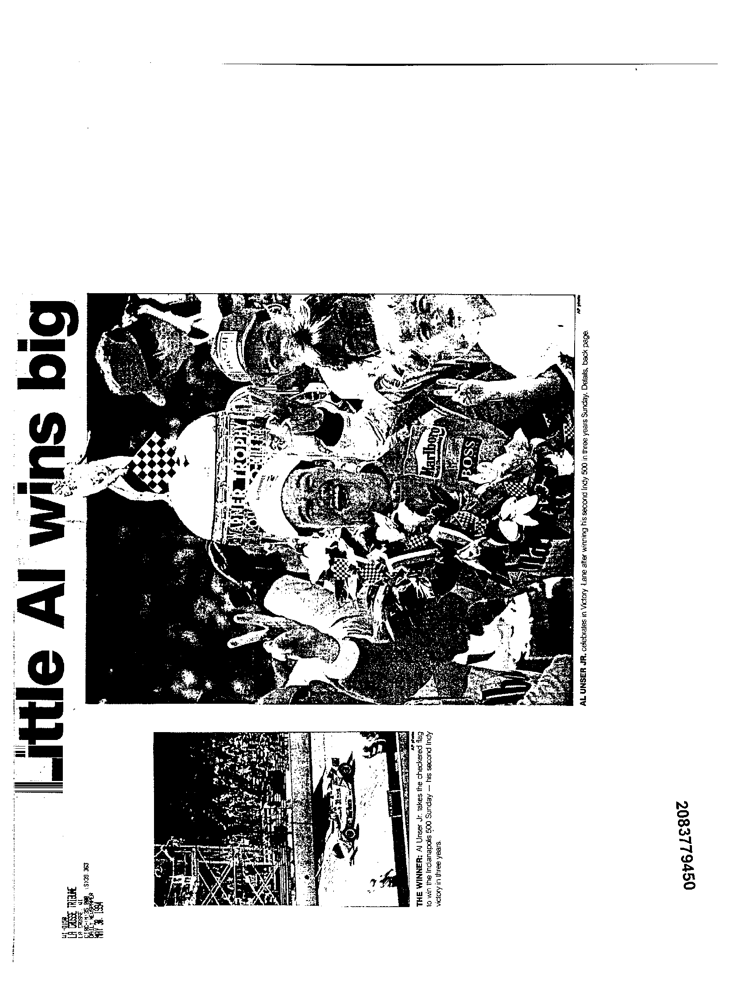


--- Explanation for Top Result (Rank #1) ---
{
  "value": 0.657415,
  "description": "within top k documents",
  "details": []
}


In [7]:
import time
import json
import re

def remove_query_vector_from_explanation(explanation_obj):
    """
    Recursively traverses the explanation object to remove the lengthy 'query_vector' parameter
    from both structured 'params' and string-based 'description' fields.
    """
    if isinstance(explanation_obj, dict):
        if 'description' in explanation_obj and isinstance(explanation_obj['description'], str):
            explanation_obj['description'] = re.sub(
                r"query_vector=\[\[.*?\]\]", 
                "query_vector=[...vector omitted for brevity...]", 
                explanation_obj['description']
            )
        if 'params' in explanation_obj and 'query_vector' in explanation_obj['params']:
            explanation_obj['params']['query_vector'] = "[...vector omitted for brevity...]"
        for key, value in explanation_obj.items():
            remove_query_vector_from_explanation(value)
    elif isinstance(explanation_obj, list):
        for item in explanation_obj:
            remove_query_vector_from_explanation(item)
    return explanation_obj

# Add a more robust query that is likely to be recovered by rescore
queries_to_test = [
    "Please find the order form I received by fax in July.",
    "지난 7월에 fax 로 받은 발주서 찾아줘"
]

def display_results(hits):
    html = "<table><tr>"
    for i, hit in enumerate(hits):
        doc_id = hit["_id"]
        score = hit["_score"]
        path = hit["_source"]["image_path"]
        category = hit["_source"]["category"]
        try:
            with open(path, "rb") as image_file:
                img_str = base64.b64encode(image_file.read()).decode()
                html += f"<td style='text-align: center; vertical-align: top; padding: 10px; border: 1px solid #ddd;'>"
                html += f"<b>Rank #{i+1}</b><br><img src='data:image/png;base64,{img_str}' width='200'><br>"
                html += f"<b>ID:</b> {doc_id[:15]}...<br><b>Score:</b> {score:.4f}<br><b>Category:</b> {category}</td>"
        except Exception as e:
            print(f"Error displaying image {path}: {e}")
    html += "</tr></table>"
    display(HTML(html))

for query in queries_to_test:
    print(f"\n{'='*20}\n--- Scenario: B. KNN Search Only ---")
    print(f"Searching for: '{query}'\n{'='*20}")

    query_avg_vector = calculate_average_vector(create_colqwen_query_vectors(query))
    
    knn_query = {
        "field": AVG_VECTOR_FIELD_NAME,
        "query_vector": query_avg_vector,
        "k": 200,
        "num_candidates": 500
    }
    
    start_time = time.time()
    results = es.search(index=INDEX_NAME, knn=knn_query, size=5, source=["image_path", "category"], explain=True)
    end_time = time.time()
    
    latency_ms = (end_time - start_time) * 1000
    print(f"🚀 Search Latency: {latency_ms:.2f} ms")

    hits = results['hits']['hits']
    
    if hits:
        display_results(hits)
        
        top_hit_explanation = hits[0].get("_explanation")
        if top_hit_explanation:
            print("\n--- Explanation for Top Result (Rank #1) ---")
            cleaned_explanation = remove_query_vector_from_explanation(top_hit_explanation)
            print(json.dumps(cleaned_explanation, indent=2))
    else:
        print("No results found.")

### Step 7: Present the Solution: KNN + Rescoring

**[EN]** Now, we solve this problem using the `rescore` API. For the top 10 documents found by the initial `knn` search, we recalculate a more precise score using `rank_vectors` to determine the final ranking. Observe how the original top-ranked document is restored.<br>
**[KR]** 이제 `rescore` API를 사용하여 이 문제를 해결합니다. 1차 `knn` 검색으로 찾은 상위 10개 문서에 대해서만, `rank_vectors`를 사용한 정밀한 점수 계산을 다시 수행하여 최종 순위를 결정합니다. 원래 1위였던 문서의 순위가 어떻게 복원되는지 확인합니다.


--- Scenario: C. KNN with Rescoring ---
Searching for: 'Please find the order form I received by fax in July.'
🚀 Search Latency: 984.65 ms



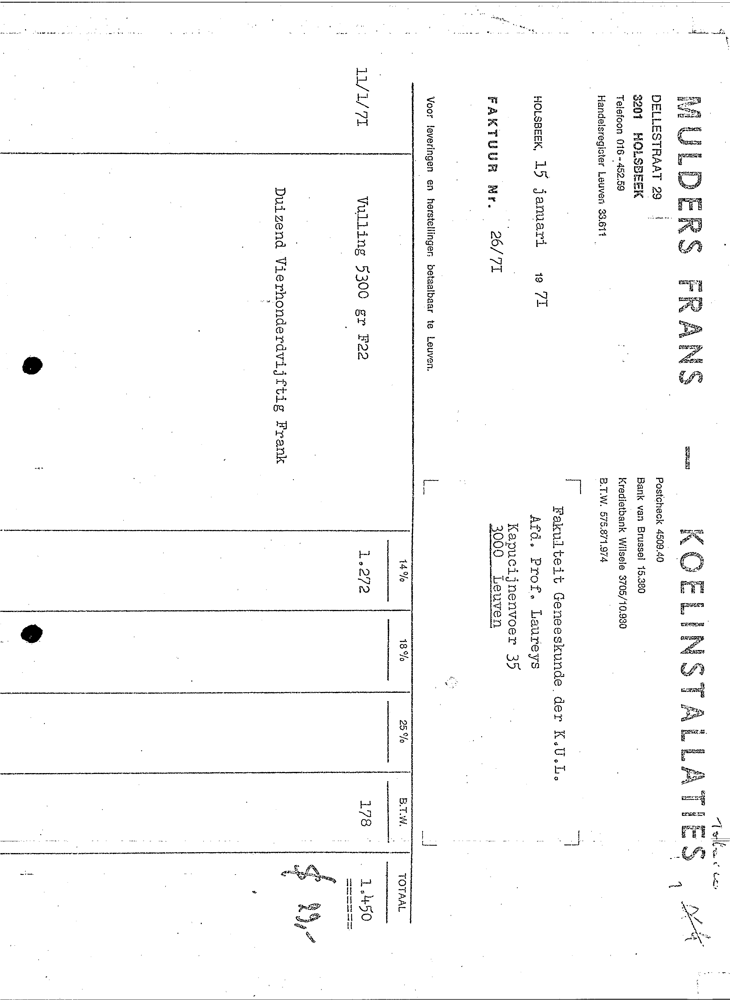
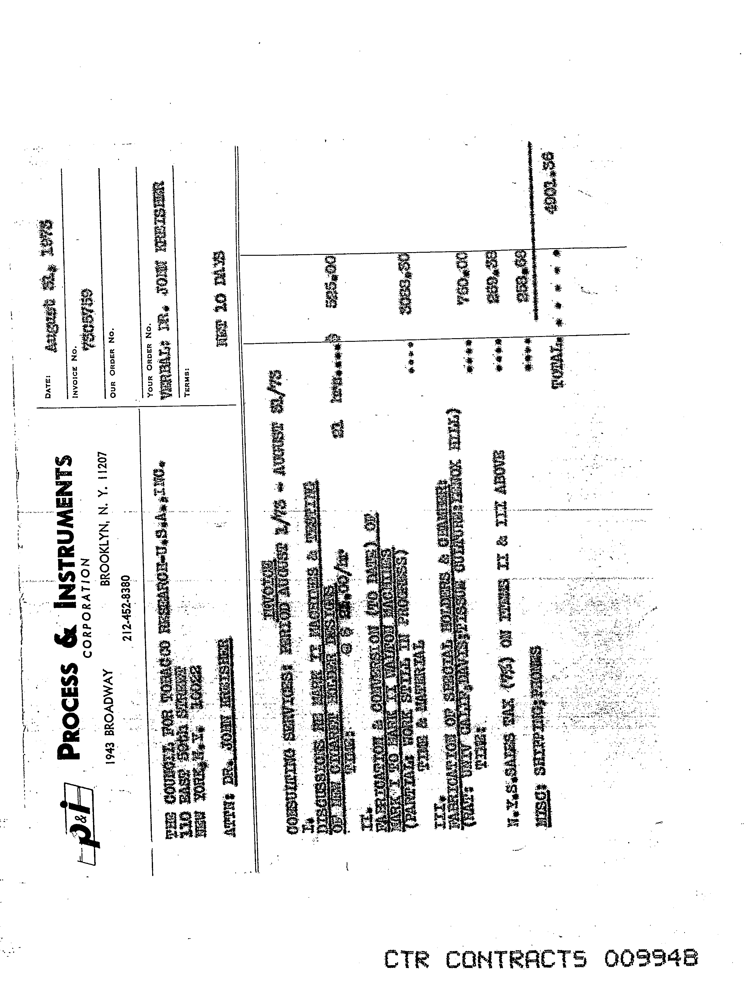
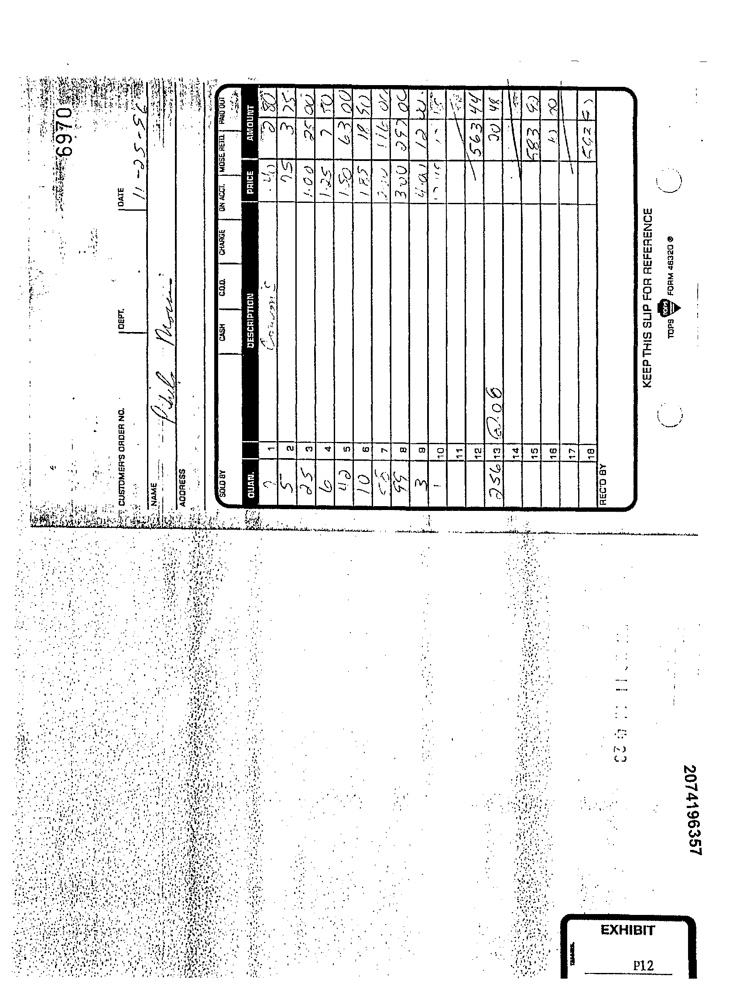
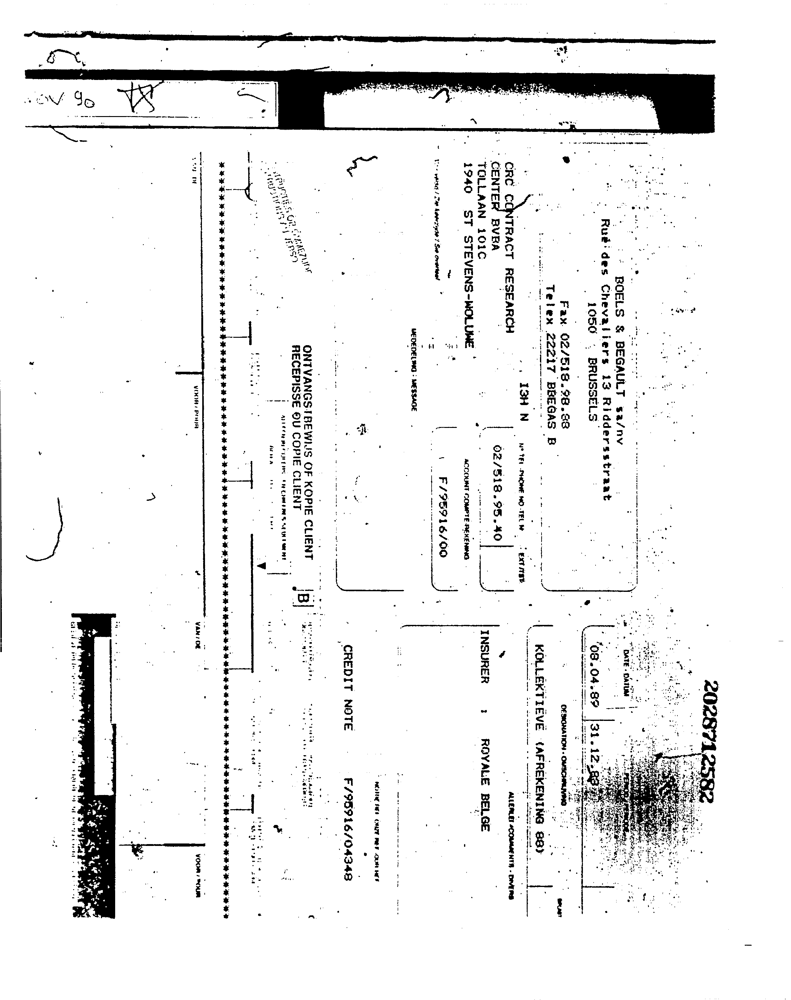
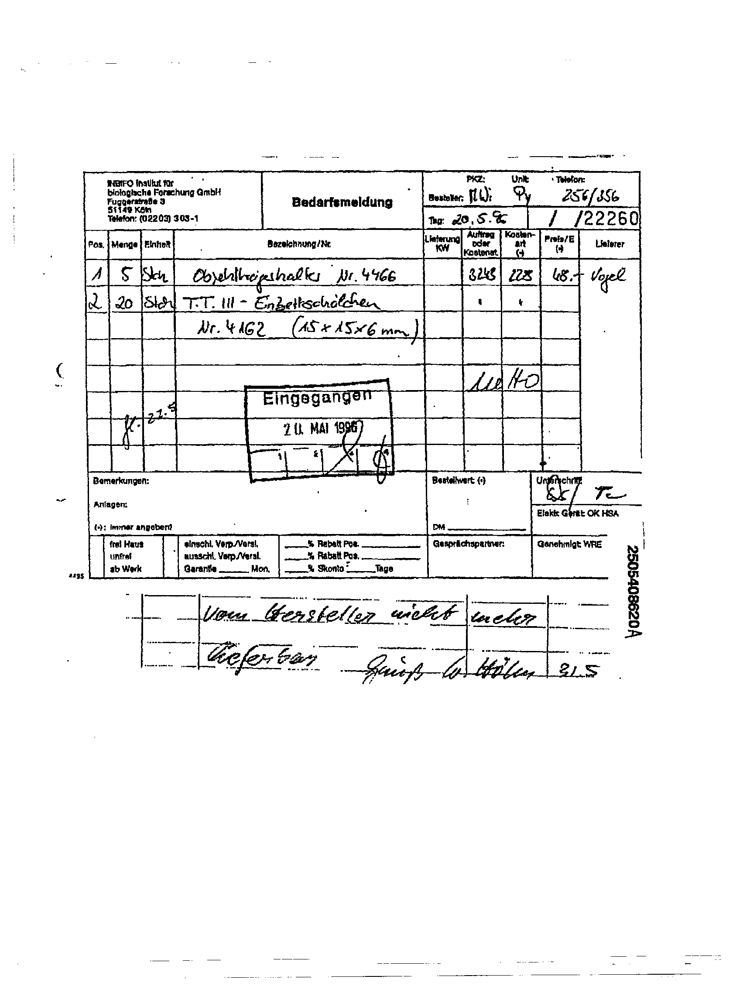


--- Explanation for Top Result (Rank #1) ---
{
  "value": 75.11844,
  "description": "sum of:",
  "details": [
    {
      "value": 0.0,
      "description": "product of:",
      "details": [
        {
          "value": 0.59354776,
          "description": "within top k documents",
          "details": []
        },
        {
          "value": 0.0,
          "description": "primaryWeight",
          "details": []
        }
      ]
    },
    {
      "value": 75.11844,
      "description": "product of:",
      "details": [
        {
          "value": 75.11844,
          "description": "script score function, computed with script:\"Script{type=inline, lang='painless', idOrCode='maxSimDotProduct(params.query_vector, 'colqwen_vectors')', options={}, params={query_vector=[...vector omitted for brevity...]}}\"",
          "details": []
        },
        {
          "value": 1.0,
          "description": "secondaryWeight",
          "details": []
        }
      ]
    }
  ]
}

--- Scenar


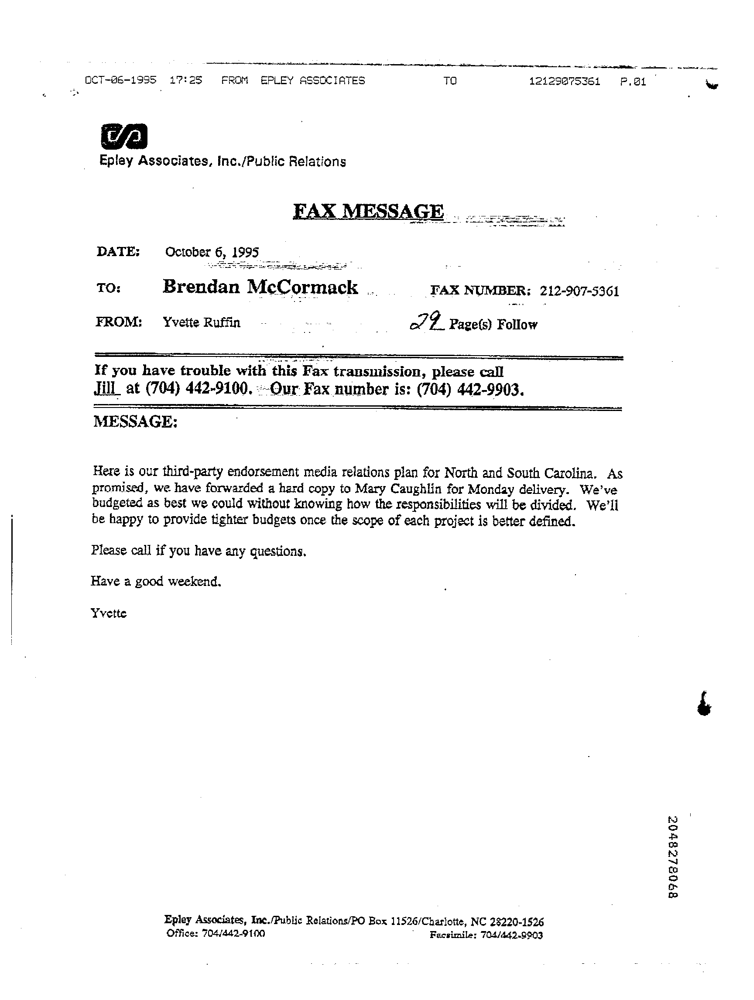
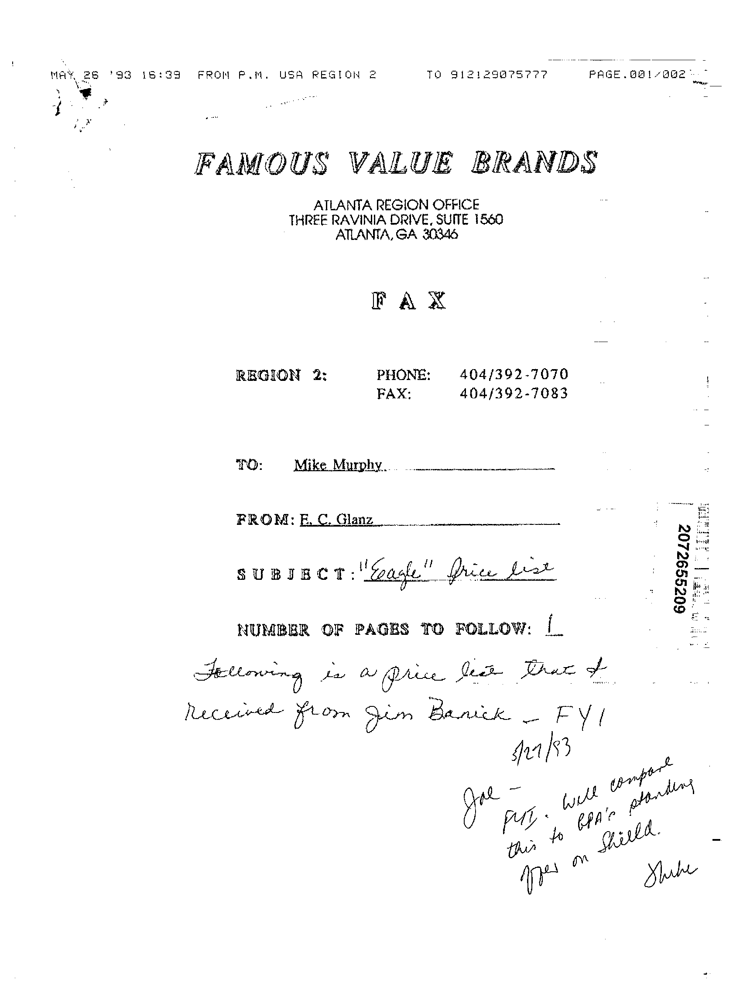
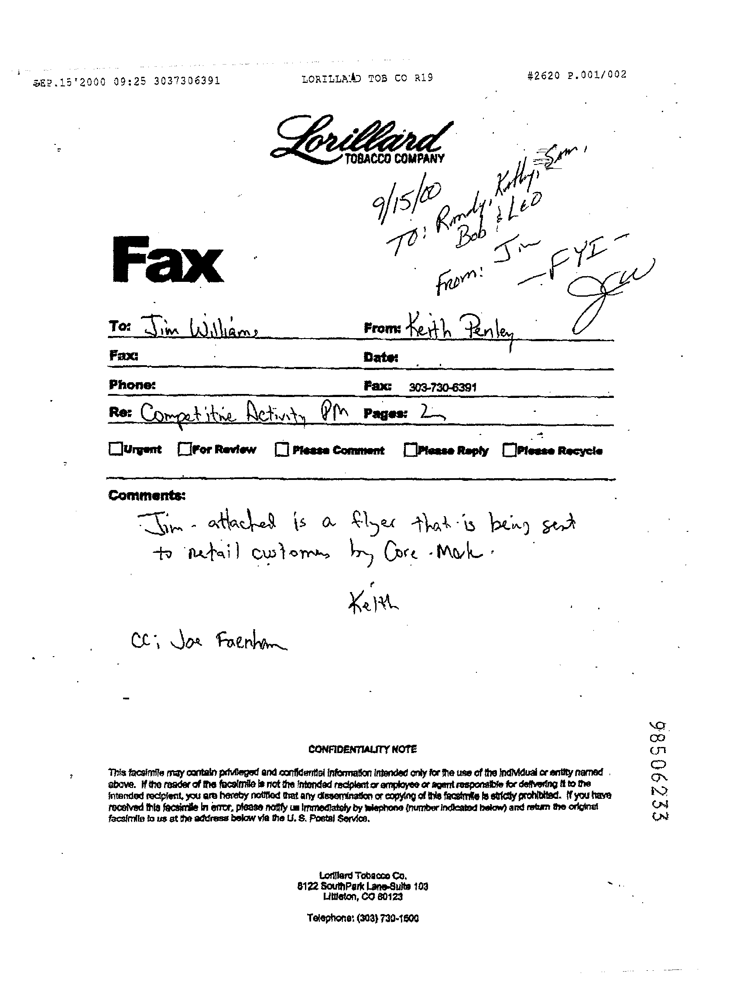
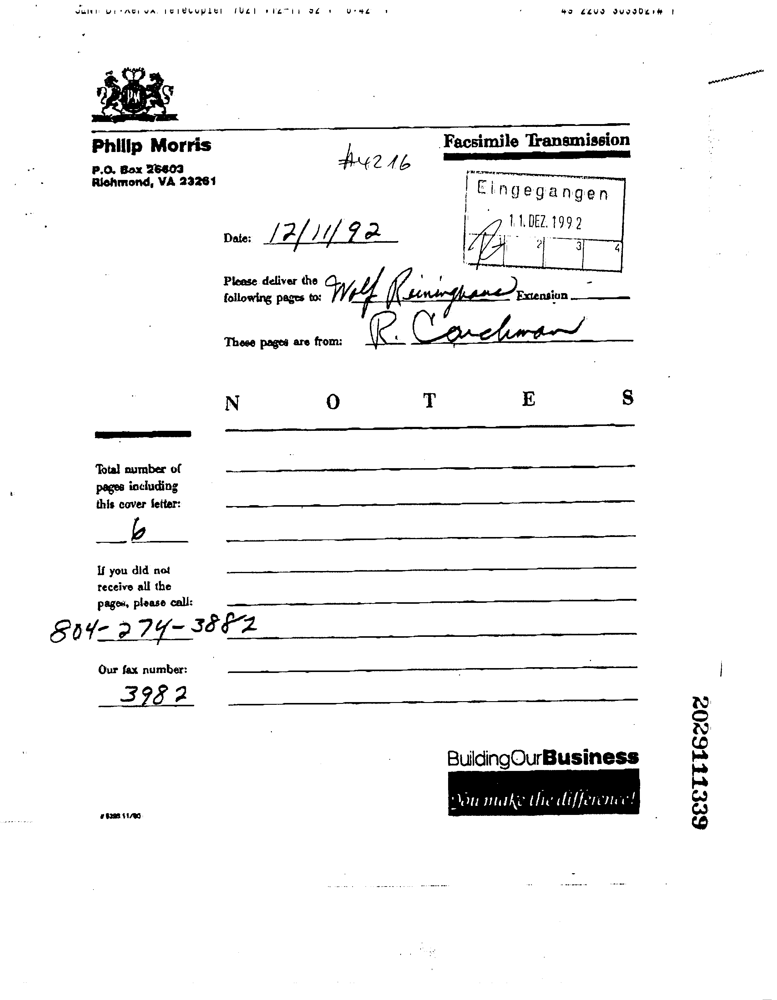
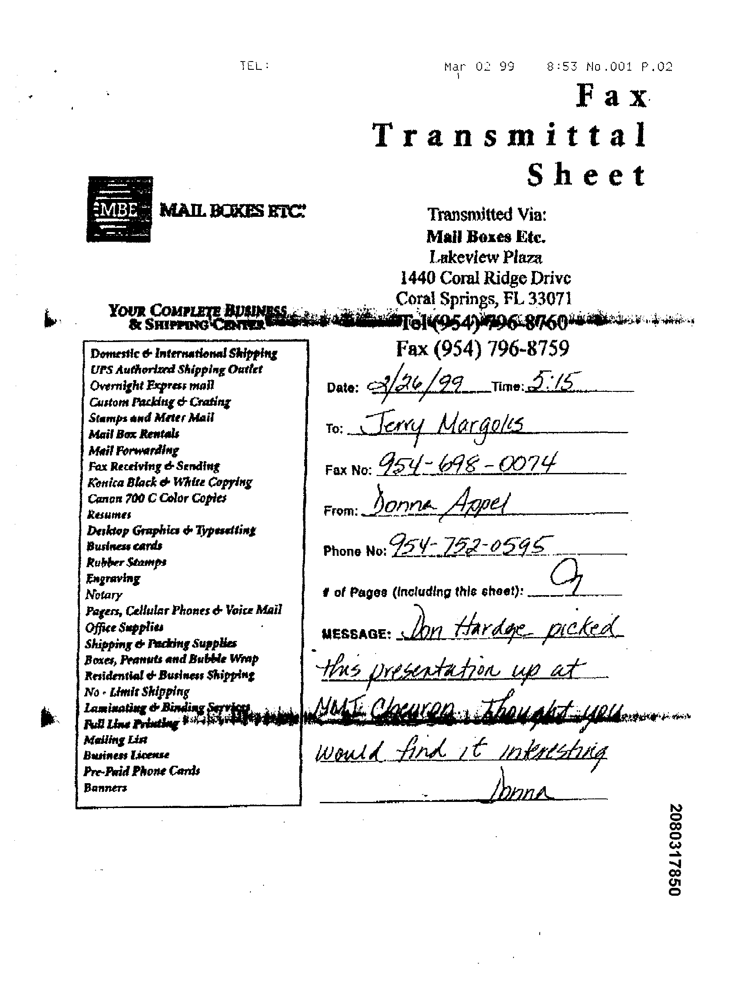


--- Explanation for Top Result (Rank #1) ---
{
  "value": 69.183426,
  "description": "sum of:",
  "details": [
    {
      "value": 0.0,
      "description": "product of:",
      "details": [
        {
          "value": 0.59854287,
          "description": "within top k documents",
          "details": []
        },
        {
          "value": 0.0,
          "description": "primaryWeight",
          "details": []
        }
      ]
    },
    {
      "value": 69.183426,
      "description": "product of:",
      "details": [
        {
          "value": 69.183426,
          "description": "script score function, computed with script:\"Script{type=inline, lang='painless', idOrCode='maxSimDotProduct(params.query_vector, 'colqwen_vectors')', options={}, params={query_vector=[...vector omitted for brevity...]}}\"",
          "details": []
        },
        {
          "value": 1.0,
          "description": "secondaryWeight",
          "details": []
        }
      ]
    }
  ]
}


In [8]:
# --- Step 7: KNN + Rescore (with Latency and Improved Parameters) ---

for query in queries_to_test:
    print(f"\n{'='*20}\n--- Scenario: C. KNN with Rescoring ---")
    print(f"Searching for: '{query}'\n{'='*20}")

    query_multi_vectors = create_colqwen_query_vectors(query)
    query_avg_vector = calculate_average_vector(query_multi_vectors)
    
    # Increase k and num_candidates to improve the chance of finding the true top result
    knn_query = {
        "field": AVG_VECTOR_FIELD_NAME,
        "query_vector": query_avg_vector,
        "k": 200,  # Widen the net
        "num_candidates": 500 # Explore more candidates
    }
    
    rescore_definition = {
        "window_size": 50, # Rescore all candidates found by knn
        "query": {
            "rescore_query": {
                "script_score": {
                    "query": {"match_all": {}},
                    "script": {
                        "source": f"maxSimDotProduct(params.query_vector, '{VECTOR_FIELD_NAME}')",
                        "params": {"query_vector": query_multi_vectors}
                    }
                }
            },
            "query_weight": 0.0,
            "rescore_query_weight": 1.0
        }
    }

    start_time = time.time()
    results = es.search(
        index=INDEX_NAME, 
        knn=knn_query, 
        rescore=rescore_definition, 
        size=5, 
        source=["image_path", "category"],
        explain=True
    )
    end_time = time.time()
    
    latency_ms = (end_time - start_time) * 1000
    print(f"🚀 Search Latency: {latency_ms:.2f} ms")

    hits = results['hits']['hits']

    if hits:
        display_results(hits)
        
        top_hit_explanation = hits[0].get("_explanation")
        if top_hit_explanation:
            print("\n--- Explanation for Top Result (Rank #1) ---")
            cleaned_explanation = remove_query_vector_from_explanation(top_hit_explanation)
            print(json.dumps(cleaned_explanation, indent=2))
    else:
        print("No results found.")

### Step 8: Free up GPU/MPS Memory

**[EN]** As a best practice, explicitly delete the model and processor to free up GPU or system memory after the demonstration is complete.<br>
**[KR]** 모범 사례로서, 데모가 완료된 후 모델과 프로세서를 명시적으로 삭제하여 GPU 또는 시스템 메모리를 확보합니다.

In [ ]:
del model
del processor

if 'torch' in locals() and 'mps' in locals() and device_map == "mps":
    torch.mps.empty_cache()
    print("MPS cache cleared.")
elif 'torch' in locals() and 'cuda' in locals() and device_map == "cuda:0":
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")
else:
    print("CPU memory will be freed by Python's garbage collector.")